In [1]:
using Pkg
Pkg.activate("../")
using LinearAlgebra
using FinNetValu
using StaticArrays
using Roots
using IntervalArithmetic, IntervalRootFinding

 Activating environment at `~/Finance/FinNetValu/Project.toml`
┌ Info: Precompiling FinNetValu [2b4a169e-d971-11e8-348f-a5a54fd349b0]
└ @ Base loading.jl:1260
┌ Info: Skipping precompilation since __precompile__(false). Importing FinNetValu [2b4a169e-d971-11e8-348f-a5a54fd349b0].
└ @ Base loading.jl:1033


In [2]:
Mˢ = [0.0 1/3; 1/4 0.0]
Mᵈ = [0.0 1/2; 1/5 0.0]
Mᵉ = I
a  = [1.0, 1.0]
d0 = [0, 0]
d1 = [5, 5]
d2 = [1, 1]
α0 = [1, 1]
α1 = [1/10, 1/10]

net1 = FinNetValu.XOSModel(Mˢ, Mᵈ, Mᵉ, d0, α0)
net2 = FinNetValu.XOSModel(Mˢ, Mᵈ, Mᵉ, d1, α0)
net3 = FinNetValu.XOSModel(Mˢ, Mᵈ, Mᵉ, d2, α0)
net4 = FinNetValu.XOSModel(Mˢ, Mᵈ, Mᵉ, d0, α1)
net5 = FinNetValu.XOSModel(Mˢ, Mᵈ, Mᵉ, d1, α1)
net6 = FinNetValu.XOSModel(Mˢ, Mᵈ, Mᵉ, d2, α1);

In [3]:
Mˢ = [0.0 1/3 0.0; 1/4 0.0 1/5; 1/10 0.0 0.0]
Mᵈ = [0.0 1/2 0.0; 1/5 0.0 1/6; 1/10 1/8 0.0]
Mᵉ = I
a  = [1.0, 1.0, 1.0]
d = Array{Float64}(undef, 4, 3)
d[1,:] = [0, 0, 0]
d[2,:] = [0, 0, 5]
d[3,:] = [0, 5, 6]
d[4,:] = [5, 6, 7]
α0 = [1, 1, 1]
α1 = [1/10, 3/10, 5/10];

In [4]:
l1 = [[]]]
l1[1] = d2[2] - Mᵈ[1,2] * d2[2];
l1[2] = d2[2] - Mᵈ[2,1] * d2[1];

LoadError: syntax: extra token "]" after end of expression

In [5]:
function number_to_label(x)
    if x == 0
        return "dd"
    elseif x == 1
        return "sd"
    elseif x == 2
        return "ds"
    else
        return "ss"
    end
end

number_to_label (generic function with 1 method)

In [6]:
using Plots
ar = 0:0.05:4
states3 = zeros(length(ar),length(ar))
states6 = zeros(length(ar),length(ar))

for (i1,a1) in enumerate(ar)
    for (i2,a2) in enumerate(ar)
        x3 = FinNetValu.fixvalue(net3, [a1,a2])
        states3[i1,i2] = sum(FinNetValu.solvent(net3, x3) .* [1,2])
        x6 = FinNetValu.fixvalue(net6, [a1,a2])
        states6[i1,i2] = sum(FinNetValu.solvent(net6, x6) .* [1,2])
    end
end
states3 = map(number_to_label, states3);
states6 = map(number_to_label, states6);

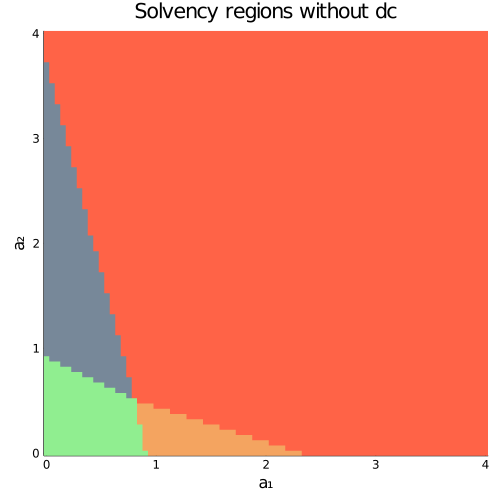

In [7]:
plt = heatmap(ar, ar, states3,c=cgrad([:LightGreen, :SandyBrown,:Tomato, :LightSlateGray]),legend = :none,
    xlabel="a₁", ylabel="a₂", grid=:false, border=nothing, size=(500,500),
    title="Solvency regions without dc")

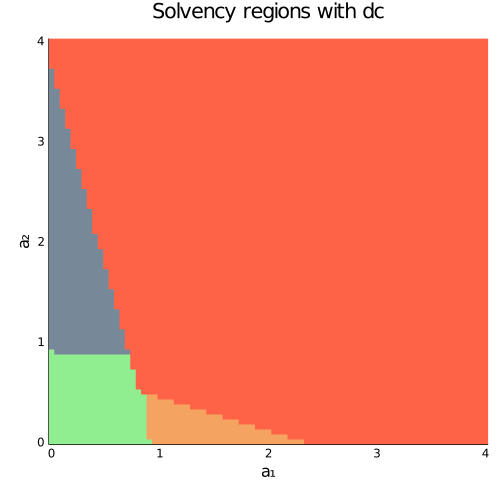

In [8]:
plt = heatmap(ar, ar, states6,c=cgrad([:LightGreen, :SandyBrown,:Tomato, :LightSlateGray]),
    xlabel="a₁", ylabel="a₂", grid=:false, border=nothing, axiscolor=nothing, size=(500,500),legend = :none,
    title="Solvency regions with dc")

# Test for jump location algo

In [144]:
set!(arr::AbstractArray, val, ind...) = begin arr[ind...] .= val; arr end

    
function bisect(f, l, r, args...; maxiter = 10^12, isize = 10^-12, allow_swap = false)
    if allow_swap
        l, r = (l > r) ? (r, l) : (l, r)
    end
    for i in 1:maxiter
        mid = (r+l)/2
        res = f(mid, args...)
        l = res < 0 ? mid : l
        r = res > 0 ? mid : r
        res == 0 && return [l,r]
        (r - l) < isize && return [l,r]
    end
    error("Maximum number of iterations exceeded")
end


function loss_db(net, aₗ, aᵣ) 
    xₗ = FinNetValu.fixvalue(net, aₗ)
    xᵣ = FinNetValu.fixvalue(net, aᵣ)
    [sum(abs.(FinNetValu.equity(xₗ) .- FinNetValu.equity(xᵣ))), 
     sum(abs.(FinNetValu.debt(xₗ) .- FinNetValu.debt(xᵣ)))]
end

function find_r(net, a, ζ, b; maxiter = 10^5)
    aint = copy(a)
    
    function f(ai, a)
        aint[b] = ai
        sum(ζ .- FinNetValu.solvent(net, FinNetValu.fixvalue(net, aint))) + 1
    end    
    l,r = bisect(f, a[b], net.N * net.d[b], a)
    aint[b] = (r+l)/2
    return aint
end

function find_db(net, aₗ, aᵣ, ζ, b; atol = 10^-10)
    aint = copy(aₗ)
    function fi(ai)
        aint[b] = ai
        res = 2*sum(FinNetValu.solvent(net, FinNetValu.fixvalue(net, aint)) .- ζ) .- 1
        return res
    end
    return bisect(fi, aₗ[b], aᵣ[b])
end

function map_db(f, net, a)
    x = FinNetValu.fixvalue(net, a)
    defaulting_banks = findall(xi -> xi == 0,FinNetValu.solvent(net, x))
    losses = zeros(length(defaulting_banks),2)
    ai = copy(a)

        
    for (bi,b) in enumerate(defaulting_banks)
        ai_l = copy(ai)
        ai_r = copy(ai)
        ζ_l = FinNetValu.solvent(net, FinNetValu.fixvalue(net, ai))
        a_r = find_r(net, ai, ζ_l, b)
        ai_l[b], ai_r[b] = find_db(net, ai, a_r, ζ_l, b)
        losses[b, :] = f(net, ai_l, ai_r)
        ai = a_r
    end
    return losses
end

map_db (generic function with 1 method)

In [145]:
a_l = [0.5, 0.5]
ζ_l = FinNetValu.solvent(net3, FinNetValu.fixvalue(net3, a_l))
a_r = find_r(net3, a_l, ζ_l, 1)
println("al: ", a_l, ", ar: ", a_r)
ab_l, ab_r = find_db(net3, a_l, a_r, ζ_l, 1)

println("no dc losses:", map_db(loss_db, net3, a_l))
println("no dc losses:", map_db(loss_db, net6, a_l))

al: [0.5, 0.5], ar: [1.25, 0.5]
no dc losses:[6.237232952344129e-13 3.254063685176334e-13; 7.276401703393276e-13 3.028688411177427e-13]
no dc losses:[4.676259379721159e-13 1.0499999999611707; 0.3149999976536779 0.6299999994132979]


In [92]:


function find_edge(net, a)
    x = FinNetValu.fixvalue(net, a)
    defaulting_banks = findall(xi -> xi == 0,FinNetValu.solvent(net, x))
    jumps = zeros(length(defaulting_banks),2)
    ai = a
    xi = x
    function find_next_jump(net, a, x, b)
        ζ_d = FinNetValu.solvent(net, x)
        a_s = a
        a_s[b] += net.d[b]
        x_s = FinNetValu.fixvalue(net, a_s)
    end
    
    for (bi,b) in enumerate(defaulting_banks)
        #jumps[bi,:], ai, xi = find_next_jump(net, ai, xi, b)
    end
    
end

find_edge (generic function with 1 method)

In [153]:
find_edge(net3, [0.5,0.5])

In [151]:
findall(x -> x == 0,FinNetValu.solvent(net3, x3))

1-element Array{Int64,1}:
 2

In [1]:
f = x -> abs(x) < 10^-8 ? 0 : sign(x)

#3 (generic function with 1 method)